In [1]:
# This code is written by A. Luke Evans, an AMSC Ph.D. of 2023
import argparse
import torch
import torch.utils.data
from torch import nn, optim
from torch.utils.data import DataLoader
from torch.nn import functional as F
import copy

import numpy as np
import matplotlib.pyplot as plt
#import src.diffusion_map as dmap
#import src.helpers as helpers
%matplotlib inline
plt.rcParams['figure.dpi'] = 100 # default is 75
plt.style.use('default')



In [2]:
np.random.seed(10)
torch.manual_seed(10)


# For defining operations on cuda if computer has it available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device} device")

Using cpu device


### Setting up Neural Network:

# 

In [3]:
class AE(nn.Module):
    def __init__(self, activation, input_dim, hidden1_dim, encoder_dim, hidden2_dim):
        super(AE, self).__init__()
        
        # Defining the layers of the neural network
        self.activation = activation
        self.hidden1 = nn.Linear(input_dim, hidden1_dim) 
        self.bottleneck = nn.Linear(hidden1_dim, encoder_dim)
        self.hidden2 = nn.Linear(encoder_dim, hidden2_dim)
        self.reconstruct = nn.Linear(hidden2_dim, input_dim)

        # Collecting layers for convenience as encoder and decoder
        self.encoder = nn.Sequential(self.hidden1, self.activation, self.bottleneck, self.activation)
        self.decoder = nn.Sequential(self.hidden2, self.activation, self.reconstruct)

    # Defined for convenience in case we want to query encoder later
    def encode(self, x):
        return self.encoder(x)

    # Defined for convenience in case we want to query decoder later
    def decode(self, z):
        return self.decoder(z)

    # Required for any subclass of nn.module: defines how data passes through the `computational graph'
    def forward(self, x):
        z = self.encode(x)
        return self.decode(z)

 

### Build two models, to train one with a "time-lagged" loss, and the other with a regular MSE loss

In [4]:
activation = nn.Tanh()
input_dim = 2
hidden1_dim = 10
encoder_dim = 1
hidden2_dim = 10 

model_lag = AE(activation, input_dim, hidden1_dim, encoder_dim, hidden2_dim).to(device)
optimizer_lag = optim.Adam(model_lag.parameters(), lr=1e-3)
loss_function = nn.MSELoss()

model_reg = copy.deepcopy(model_lag)
optimizer_reg = optim.Adam(model_reg.parameters(), lr=1e-3)



# NOTE:

### Pytorch is written and used in an "object oriented programming" style, and familiarizing with object oriented programming concepts in Python may be helpful, e.g see [here](https://realpython.com/python3-object-oriented-programming/)

# Writing a custom dataset class in Pytorch


The torch.utils.data module has the tools for defining how a dataset is loaded, batched, and sampled for training/testing in pytorch

- [torch.utils.data documentation](https://pytorch.org/docs/stable/data.html#module-torch.utils.data)

- [Pytorch tutorial on datasets/dataloaders, for image datasets](https://pytorch.org/tutorials/beginner/data_loading_tutorial.html)

- [Tutorial on datasets/dataloaders, for text datasets](https://towardsdatascience.com/how-to-use-datasets-and-dataloader-in-pytorch-for-custom-text-data-270eed7f7c00)

All classes that subclass *Dataset* have to write their own `__getitem__` method, and optionally their own `__len__` method
- `__init__`: defines what we need to input when we create an instance of our object
- `__getitem__`: defines what is returned when the object is accessed
- `__len__`: defines what length of object is in Python

- `MyDataset` is a very generic example, we can read in a Torch tensor data object as the `data_tensor` for initializing
- `LaggedDataset` is implemented so that when queried, it will return **pairs** of data points, the data point queried **and** the time-lagged data point. 

In [5]:
class MyDataset(torch.utils.data.Dataset):
    """Basic dataset container

    Parameters
    ----------
     data_tensor : (num_features, num_data) Tensor
         
    """    
    def __init__(self, data_tensor):
        self.data_tensor = data_tensor
    def __getitem__(self, index):
        return self.data_tensor[index]
    def __len__(self):
        return self.data_tensor.size(0)

class LaggedDataset(torch.utils.data.Dataset):
    """ Container for creating and utilizing time-lagged time-series

    Parameters
    ----------
        data_tensor : (num_features, num_data) Tensor
            time series dataset
        lag: integer
            number of frames for time-lag
    """    
    def __init__(self, data_tensor, lag=1):
        assert data_tensor.size(0) > lag, 'you need more samples than lag'
        assert lag >= 0, 'you need a non-negative lagtime'
        self.data_tensor = data_tensor
        self.lag = lag
    def __getitem__(self, index):
        return self.data_tensor[index], self.data_tensor[index + self.lag]
    def __len__(self):
        return self.data_tensor.size(0) - self.lag


### A quick example for accessing these:

In [6]:
print("Dataset with 5 data points, 2 features:")
my_tensor = torch.randn(5, 2)
print(my_tensor)

dataset = MyDataset(my_tensor)

print("\n")

print("Using __getitem__ with MyDataset: ")
print(f"Dataset index 0: {dataset[0]}")
print(f"Dataset index 2: {dataset[2]}")

print("\n")

lagged_dataset = LaggedDataset(my_tensor, lag=2)
print("Using __getitem__ with LaggedDataset:")
print(f"lagged dataset index 0: {lagged_dataset[0]}")
print(f"lagged dataset index 2: {lagged_dataset[2]}")




Dataset with 5 data points, 2 features:
tensor([[ 0.1913,  1.2856],
        [ 0.9063, -0.5357],
        [ 0.8521, -1.1959],
        [ 0.1084,  0.7363],
        [-0.9149, -0.1433]])


Using __getitem__ with MyDataset: 
Dataset index 0: tensor([0.1913, 1.2856])
Dataset index 2: tensor([ 0.8521, -1.1959])


Using __getitem__ with LaggedDataset:
lagged dataset index 0: (tensor([0.1913, 1.2856]), tensor([ 0.8521, -1.1959]))
lagged dataset index 2: (tensor([ 0.8521, -1.1959]), tensor([-0.9149, -0.1433]))


# Define training and testing:

This is adapted from the [Pytorch Optimizing Model Parameters Tutorial](https://pytorch.org/tutorials/beginner/basics/optimization_tutorial.html) from the "Full Implementation" section at the bottom,

Changes:
- In ''train_time_lagged'' We are comparing outputs of the autoencoder (recon_data) with time-lagged data (data_lagged), instead of images with labels
- we are using the [MSEloss()](https://pytorch.org/docs/stable/generated/torch.nn.MSELoss.html) as the loss function
- In this notebook we are not investigating test error
- We are inputting 'model' and 'optimizer in the train, test functions since we are trying some different kinds of those


In [7]:
def train_time_lagged(model, optimizer, epoch, train_loader):
    model.train()
    train_loss = 0
    
    # Note that we are grabbing pairs (data, data_lagged) for each iteration
    for batch_idx, (data, data_lagged) in enumerate(train_loader):
        data = data.to(device)
        data_lagged = data_lagged.to(device)
        recon_data = model(data.float())
        optimizer.zero_grad()
        loss = loss_function(recon_data, data_lagged.float())
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
    print('====> Average loss: {:.4f}'.format(
          train_loss / len(train_loader.dataset)))

def train(model, optimizer, epoch, train_loader):
    model.train()
    train_loss = 0
    
    for batch_idx, data in enumerate(train_loader):
        data = data.to(device)
        recon_data = model(data.float())
        optimizer.zero_grad()
        loss = loss_function(recon_data, data.float())
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
    print('====> Average loss: {:.4f}'.format(
          train_loss / len(train_loader.dataset)))

def test(model, epoch, test_loader):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        # Note that we are grabbing pairs (data, data_lagged) for each iteration
        for i, (data, data_lagged) in enumerate(test_loader):
            data = data.to(device)
            data_lagged = data_lagged.to(device)
            recon_data = model(data.float())
            test_loss += loss_function(recon_data, data_lagged.float()).item()
    test_loss /= len(test_loader.dataset)
    print('====> Test set loss: {:.4f}'.format(test_loss))



### Setting up stochastic differential equation dynamics,
$$ dx_t = -\nabla Potential(x_t)dt + \sqrt{2\beta^{-1}}dw_t$$

The example below is the "lemon-slice" (?) potential so named by Nuske, Kolta, Boninsegna and Clementi in https://www.mdpi.com/1099-4300/23/2/134, section 4.2 equation (27). It's a nice toy example due to that the generator can be analytically determined in the reduced coordinate given by the polar angle $\phi.$

In [8]:
def potential(x):
    r = (x[0]**2 + x[1]**2)**(0.5)
    phi = np.arctan2(x[1], x[0])
    V = np.cos(4*phi) + (np.cos(0.5*phi))**(-1) + 10*(r - 1)**2 + r**(-1)
    return V

def drift(x):
    r = (x[0]**2 + x[1]**2)**(0.5)
    phi = np.arctan2(x[1], x[0])
    
    # derivs with respect to radius, angle 
    dr = 20*(r-1) - r**(-2)
    dphi = -4*np.sin(4*phi) + 0.5*np.sin(0.5*phi)/(np.cos(0.5*phi))**(2)

    # derivs with respect to cartesian coords 
    dx0 = dphi*(-x[1]/r**2) + dr*(x[0]/r)
    dx1 = dphi*x[0]/r**2 + dr*(x[1]/r)
    return -1*np.array([dx0, dx1])

### Plot Potential Function on a grid

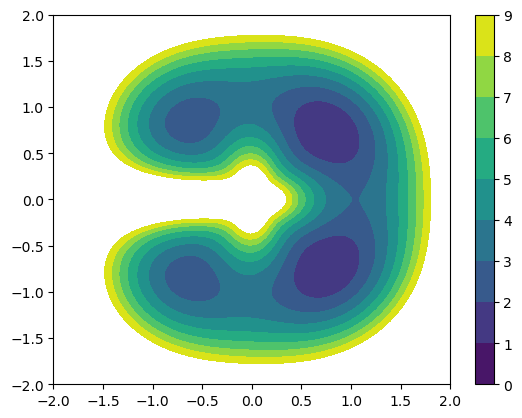

In [9]:
xmin, xmax = -2, 2
ymin, ymax = -2, 2
x = np.linspace(xmin, xmax, 100)
y = np.linspace(ymin, ymax, 100)
xx, yy = np.meshgrid(x, y)
Vgrid = np.zeros((yy.shape[0], xx.shape[0]))
for i in range(yy.shape[0]):
    for j in range(xx.shape[0]):
        Vgrid[i, j] = potential(np.array([xx[i, j], yy[i, j]]))
plt.contourf(xx, yy, Vgrid, levels=np.arange(0, 10, 1))
plt.colorbar()
plt.savefig('LemonSlicePotential.pdf')

### Simulate a Dataset and Save, or Load one

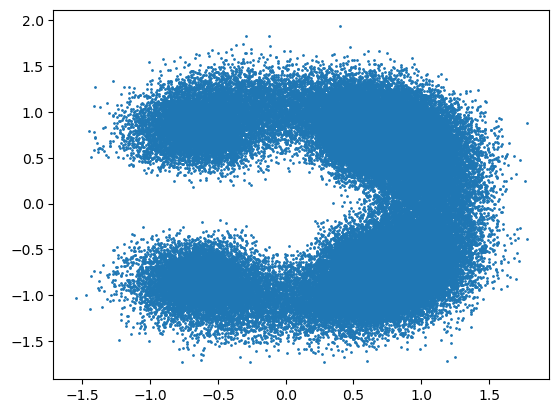

In [10]:
SIMULATE = False

if SIMULATE:

    beta = 1    # 1/beta is the `temperature`/ noise parameter
    dt = 0.001
    num_steps = 1000000  # total simulation steps
    sub_steps = 10       # frequency of subsampling steps
    num_points = num_steps // sub_steps

    x_init = np.array([1, 0])
    data = np.zeros((2, num_points))
    data[:, 0] = x_init
    
    step = 0    # simulation step
    n = 0       # index of subsampled step
    x = x_init 
    while n < num_points - 1:
        # Run a simulator step 
        x = x + drift(x)*dt + np.sqrt((2.0/beta)*dt)*np.random.normal(size=2)
        step +=1 
        
        # Save new timestep if applicable, update subsampled count 
        if step % sub_steps == 0:
            data[:, n + 1] = x
            n +=1

plt.figure()
#save_fname = "new_dataset.npz"
#np.savez(save_fname, data=data, dt=dt, num_steps=num_steps, sub_steps=sub_steps, num_points=num_points)
load_fname = "dataset.npz"

inData = np.load(load_fname)
data = inData["data"]
num_points = inData["num_points"]
plt.scatter(data[0, :], data[1, :], s=1.0)
beta=1



### Define Training Data and Test Data

In [11]:
train_data = data[:, ::2]
test_data = data[:, 1:num_points-2:2]

### Run the Neural Network

We will train a `time-lagged' auto-encoder and a regular auto-encoder

In [12]:
lag = 10
batch_size = 128
num_epochs = 50

lagged_data = LaggedDataset(torch.from_numpy(train_data.T), lag=lag) # .T means transposition
train_loader = torch.utils.data.DataLoader(lagged_data, batch_size=batch_size, shuffle=True)

for epoch in range(num_epochs):
    print(f"epoch {epoch}:")
    train_time_lagged(model_lag, optimizer_lag, epoch, train_loader)

regular_data = MyDataset(torch.from_numpy(train_data.T))
train_loader = torch.utils.data.DataLoader(regular_data, batch_size=batch_size, shuffle=True)

for epoch in range(num_epochs):
    print(f"epoch {epoch}:")
    train(model_reg, optimizer_reg, epoch, train_loader)


#test_loader = torch.utils.data.DataLoader(test_data.T, batch_size=batch_size)



epoch 0:
====> Average loss: 0.0031
epoch 1:
====> Average loss: 0.0020
epoch 2:
====> Average loss: 0.0019
epoch 3:
====> Average loss: 0.0019
epoch 4:
====> Average loss: 0.0019
epoch 5:
====> Average loss: 0.0017
epoch 6:
====> Average loss: 0.0015
epoch 7:
====> Average loss: 0.0015
epoch 8:
====> Average loss: 0.0014
epoch 9:
====> Average loss: 0.0013
epoch 10:
====> Average loss: 0.0012
epoch 11:
====> Average loss: 0.0012
epoch 12:
====> Average loss: 0.0012
epoch 13:
====> Average loss: 0.0012
epoch 14:
====> Average loss: 0.0011
epoch 15:
====> Average loss: 0.0011
epoch 16:
====> Average loss: 0.0011
epoch 17:
====> Average loss: 0.0011
epoch 18:
====> Average loss: 0.0011
epoch 19:
====> Average loss: 0.0011
epoch 20:
====> Average loss: 0.0011
epoch 21:
====> Average loss: 0.0011
epoch 22:
====> Average loss: 0.0011
epoch 23:
====> Average loss: 0.0011
epoch 24:
====> Average loss: 0.0011
epoch 25:
====> Average loss: 0.0011
epoch 26:
====> Average loss: 0.0011
epoch 27:
=

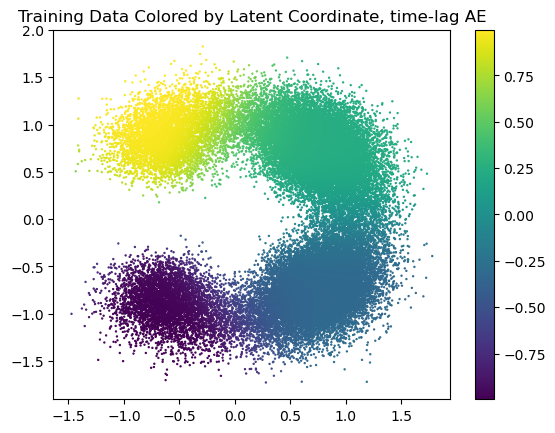

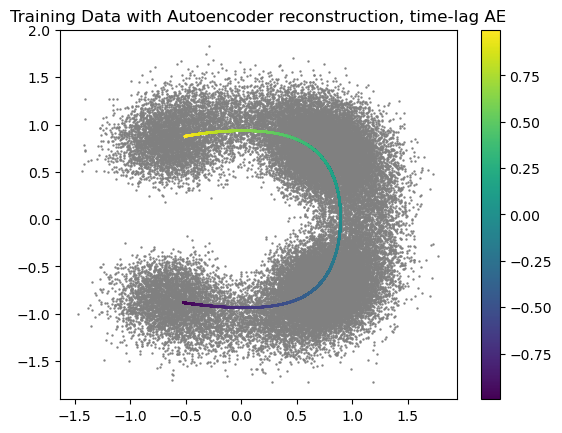

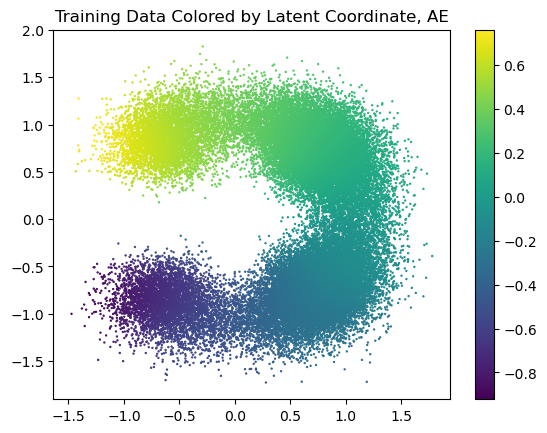

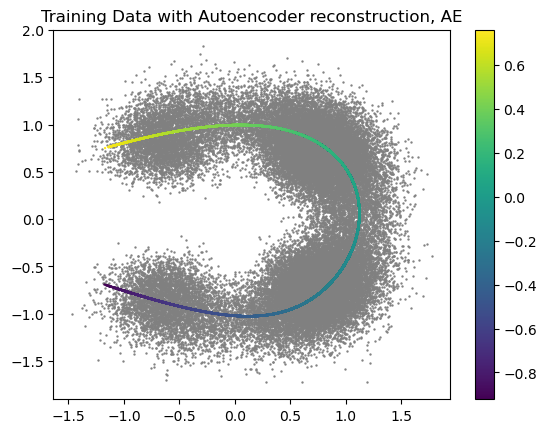

In [16]:
z = model_lag.encode(torch.from_numpy(train_data.T).float()).detach()
data_recon = model_lag.decode(z).T.detach()
data_recon = data_recon.numpy()
plt.figure()
plt.title("Training Data Colored by Latent Coordinate, time-lag AE")
plt.scatter(train_data[0, :], train_data[1, :], s=0.5, c=z)
#plt.scatter(z[:, 0], z[:, 1], s=0.5)
plt.colorbar()

plt.figure()
plt.title("Training Data with Autoencoder reconstruction, time-lag AE")
plt.scatter(train_data[0, :], train_data[1, :], color="grey", s=0.5)
plt.scatter(data_recon[0, :], data_recon[1, :], s=0.5, c=z)
plt.colorbar()


###################################

z = model_reg.encode(torch.from_numpy(train_data.T).float()).detach()
data_recon = model_reg.decode(z).T.detach()
data_recon = data_recon.numpy()
plt.figure()
plt.title("Training Data Colored by Latent Coordinate, AE")
plt.scatter(train_data[0, :], train_data[1, :], s=0.5, c=z)
#plt.scatter(z[:, 0], z[:, 1], s=0.5)
plt.colorbar()
plt.savefig('LemonSliceLatentCoordinate.pdf')

plt.figure()
plt.title("Training Data with Autoencoder reconstruction, AE")
plt.scatter(train_data[0, :], train_data[1, :], color="grey", s=0.5)
plt.scatter(data_recon[0, :], data_recon[1, :], s=0.5, c=z)
plt.colorbar()
plt.savefig('LemonSliceLatentCoordinateReconstruction.pdf')



### Jacobian Stuff

In [14]:
data_sample = data[:, ::5]
N = data_sample.shape[1]
x = torch.from_numpy(data_sample).float()
x.requires_grad = True
C_enc_lag = np.zeros(N)
C_full_lag = np.zeros((N, 2))
for i in range(N):
    # Run data point through auto_encoder 
    datum = x[:, i]
    z_datum = model_lag.encode(datum)
    x_recon_datum = model_lag.decode(z_datum)
    
    # Calculate Jacobian*Jacobian.T for full encoder x -> z
    J_enc = torch.autograd.grad(z_datum, datum, create_graph=True)[0].detach().numpy()
    C_enc_lag[i] = J_enc.dot(J_enc)

    # Calculate Jacobian*Jacobian.T for full auto-encoder x -> z -> x_reconstruct
    J_full = np.zeros((2,2))
    J_full[0, :] = torch.autograd.grad(x_recon_datum[0], datum, create_graph=True)[0].detach().numpy()
    J_full[1, :] = torch.autograd.grad(x_recon_datum[1], datum, create_graph=True)[0].detach().numpy()
    JJT_full = J_full.dot(J_full.T)
    evals, evecs = np.linalg.eig(JJT_full)
    idx = evals.argsort()[::-1]
    evals = evals[idx]
    evecs = evecs[:, idx]
    C_full_lag[i, :] = evecs[:, 0]*evals[0]


C_enc_reg = np.zeros(N)
C_full_reg = np.zeros((N, 2))
for i in range(N):
    # Run data point through auto_encoder 
    datum = x[:, i]
    z_datum = model_reg.encode(datum)
    x_recon_datum = model_reg.decode(z_datum)
    
    # Calculate Jacobian*Jacobian.T for full encoder x -> z
    J_enc = torch.autograd.grad(z_datum, datum, create_graph=True)[0].detach().numpy()
    C_enc_reg[i] = J_enc.dot(J_enc)

    # Calculate Jacobian*Jacobian.T for full auto-encoder x -> z -> x_reconstruct
    J_full = np.zeros((2,2))
    J_full[0, :] = torch.autograd.grad(x_recon_datum[0], datum, create_graph=True)[0].detach().numpy()
    J_full[1, :] = torch.autograd.grad(x_recon_datum[1], datum, create_graph=True)[0].detach().numpy()
    JJT_full = J_full.dot(J_full.T)
    evals, evecs = np.linalg.eig(JJT_full)
    idx = evals.argsort()[::-1]
    evals = evals[idx]
    evecs = evecs[:, idx]
    C_full_reg[i, :] = evecs[:, 0]*evals[0]

# Compute Gibbs measure on sample data
measure = np.zeros(N)
for i in range(N):
    measure[i] = np.exp(-beta*potential(data_sample[:, i]))


### Plot Jacobian-related data

Depending on the "C_full" data, the *scale* parameter for plt.quiver may need to be adjusted for visualization

Text(0.5, 1.0, 'Norm^2 of Jacobian encoder, weighted by gibbs, AE')

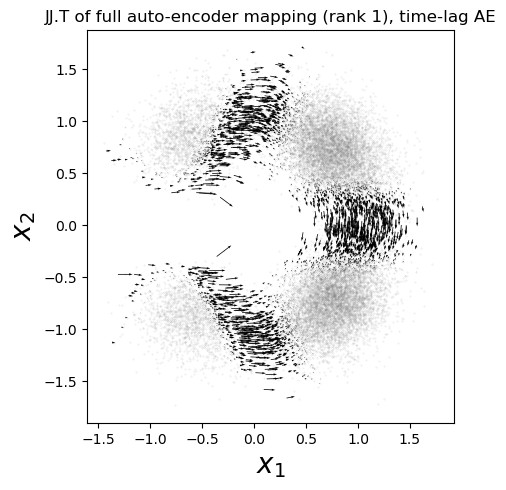

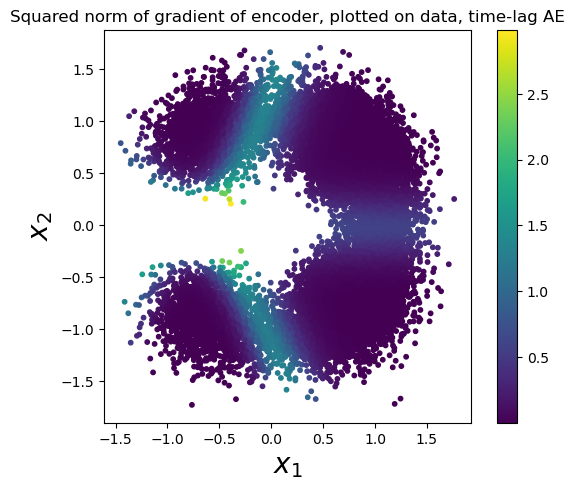

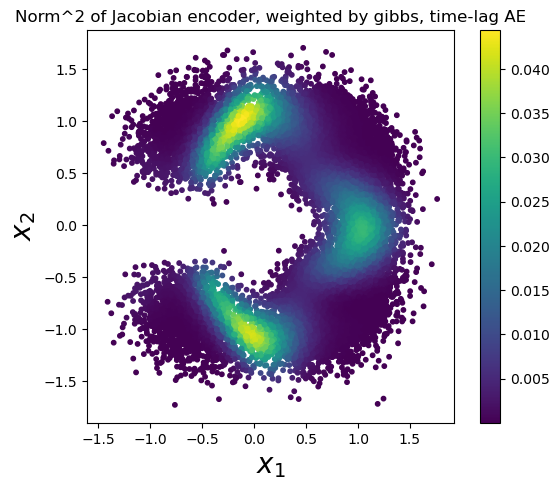

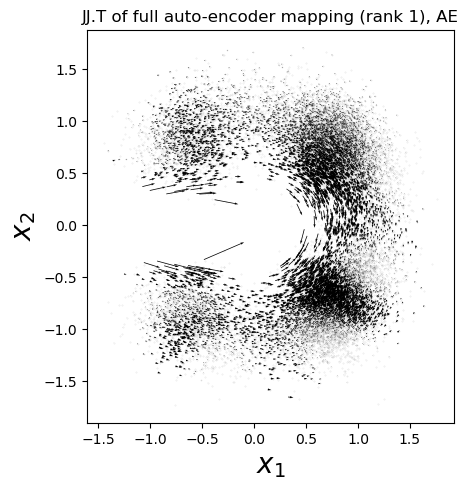

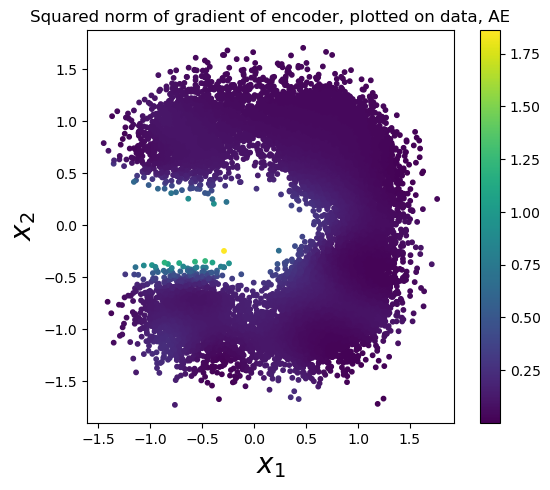

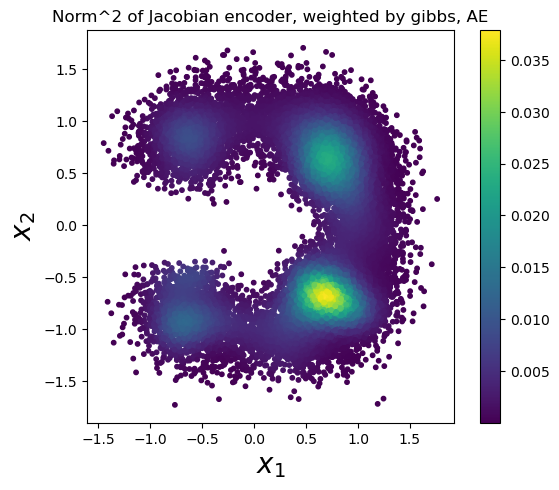

In [15]:
plt.figure()
plt.scatter(data_sample[0, :], data_sample[1, :], s=0.1, c="gray", alpha=0.2)
plt.quiver(data_sample[0, ::2], data_sample[1, ::2], C_full_lag[::2, 0], C_full_lag[::2, 1], angles='xy', scale_units='xy',
                    scale=50, width=0.002, minlength=0, pivot="mid")
plt.xlabel(r'$x_1$', size=20)
plt.ylabel(r'$x_2$', size=20)
plt.tight_layout()
plt.gca().set_aspect('equal', adjustable='box')
plt.title("JJ.T of full auto-encoder mapping (rank 1), time-lag AE")

plt.figure()
plt.scatter(data_sample[0, :], data_sample[1, :], s=10, c=C_enc_lag)
plt.colorbar()
plt.xlabel(r'$x_1$', size=20)
plt.ylabel(r'$x_2$', size=20)
plt.tight_layout()
plt.gca().set_aspect('equal', adjustable='box')
plt.title("Squared norm of gradient of encoder, plotted on data, time-lag AE")

plt.figure()
plt.scatter(data_sample[0, :], data_sample[1, :], s=10, c=C_enc_lag*measure)
plt.colorbar()
plt.xlabel(r'$x_1$', size=20)
plt.ylabel(r'$x_2$', size=20)
plt.tight_layout()
plt.gca().set_aspect('equal', adjustable='box')
plt.title("Norm^2 of Jacobian encoder, weighted by gibbs, time-lag AE")

##################################################

plt.figure()
plt.scatter(data_sample[0, :], data_sample[1, :], s=0.1, c="gray", alpha=0.2)
plt.quiver(data_sample[0, ::2], data_sample[1, ::2], C_full_reg[::2, 0], C_full_reg[::2, 1], angles='xy', scale_units='xy',
                    scale=50, width=0.002, minlength=0, pivot="mid")
plt.xlabel(r'$x_1$', size=20)
plt.ylabel(r'$x_2$', size=20)
plt.tight_layout()
plt.gca().set_aspect('equal', adjustable='box')
plt.title("JJ.T of full auto-encoder mapping (rank 1), AE")

plt.figure()
plt.scatter(data_sample[0, :], data_sample[1, :], s=10, c=C_enc_reg)
plt.colorbar()
plt.xlabel(r'$x_1$', size=20)
plt.ylabel(r'$x_2$', size=20)
plt.tight_layout()
plt.gca().set_aspect('equal', adjustable='box')
plt.title("Squared norm of gradient of encoder, plotted on data, AE")

plt.figure()
plt.scatter(data_sample[0, :], data_sample[1, :], s=10, c=C_enc_reg*measure)
plt.colorbar()
plt.xlabel(r'$x_1$', size=20)
plt.ylabel(r'$x_2$', size=20)
plt.tight_layout()
plt.gca().set_aspect('equal', adjustable='box')
plt.title("Norm^2 of Jacobian encoder, weighted by gibbs, AE")

